<a href="https://colab.research.google.com/github/bgpayne23/mirahealth/blob/main/Mira_Health_Ops_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mira Health Ops Pipeline

## Importing Libraries

In [3]:
import pandas as pd
#!pip install ctgan
from ctgan import CTGAN
#!pip install table_evaluator
from table_evaluator import TableEvaluator

##Step 1: Data Ingestion

The first step in building a Mira Health model is for the Client to injest patient and provider data from various sources, such as databases, APIs and flat files. **Since health care data is typically highly protected, IBM cannot be directly involved in this step.** However, IBM must still consult with the Client to ensure that the data being ingested is high quality, consistent, representative, and relevant to the goal of scoring the likelihood of a medical complication.

As an example, a file named pregnant_patient_dataset.csv is brought in to represent a successful data ingestion by the Client.


### 1a. Read injested data

In [4]:
# Enter the full pathname for the client dataset
real_data = pd.read_csv ('https://raw.githubusercontent.com/bgpayne23/mirahealth/main/datasets/pregnant_patient_dataset.csv')
real_data.head()

,obgyn_id,obgyn_Gender,obgyn_Location,obgyn_Ethnicity,obgyn_AvgPatientTime,obgyn_NumOfPatients,obgyn_BurnoutRisk,obgyn_Sentiment,patient_Age,patient_Ethnicity,patient_Payer,patient_Location,patient_Income,patient_HospitalRegion,patient_SystolicBP,patient_DiastolicBP,patient_BS,patient_HDP
0,O1,Female,Metropolitan,White,17,24,0,0,34,Hispanic,Public,Metropolitan,Q2,South,113.690770,91.676094,8.498975,0
1,O1,Female,Metropolitan,White,17,24,0,0,12,Black,Public,Micropolitan,Q3,Midwest,70.000000,97.743656,7.068305,0
2,O1,Female,Metropolitan,White,17,24,0,0,29,American Indian and Alaska Native,Public,Metropolitan,Q4,South,133.230561,73.876909,6.000000,0
3,O1,Female,Metropolitan,White,17,24,0,0,27,Missing,Uninsured,Rural,Q1,Northeast,117.163245,93.207835,8.293301,0
4,O1,Female,Metropolitan,White,17,24,0,0,14,Another race,Private,Micropolitan,Q1,Midwest,98.239531,60.554483,12.315787,0


### 1b. Remove irrelevant features

In [5]:
# Drop columns containg irrelevant features, such as obgyn IDs
real_data = real_data.drop("obgyn_id", axis=1)

### 1c. One hot encode the dataset

In [21]:
# Identify categorical columns
categorical_columns = real_data.select_dtypes(include=['object']).columns.tolist()

# Perform one-hot encoding for categorical columns only
df_encoded = pd.get_dummies(real_data, columns=categorical_columns)
df_encoded

,obgyn_AvgPatientTime,obgyn_NumOfPatients,obgyn_BurnoutRisk,obgyn_Sentiment,patient_Age,patient_SystolicBP,patient_DiastolicBP,patient_BS,patient_HDP,obgyn_Gender_Female,...,patient_Location_Micropolitan,patient_Location_Rural,patient_Income_Q1,patient_Income_Q2,patient_Income_Q3,patient_Income_Q4,patient_HospitalRegion_Midwest,patient_HospitalRegion_Northeast,patient_HospitalRegion_South,patient_HospitalRegion_West
0,17,24,0,0,34,113.690770,91.676094,8.498975,0,1,...,0,0,0,1,0,0,0,0,1,0
1,17,24,0,0,12,70.000000,97.743656,7.068305,0,1,...,1,0,0,0,1,0,1,0,0,0
2,17,24,0,0,29,133.230561,73.876909,6.000000,0,1,...,0,0,0,0,0,1,0,0,1,0
3,17,24,0,0,27,117.163245,93.207835,8.293301,0,1,...,0,1,1,0,0,0,0,1,0,0
4,17,24,0,0,14,98.239531,60.554483,12.315787,0,1,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,29,20,0,0,35,121.781195,53.354316,7.682974,0,1,...,0,0,1,0,0,0,0,0,0,1
471,29,20,0,0,17,113.706968,49.000000,10.332211,0,1,...,1,0,0,0,1,0,0,0,0,1
472,29,20,0,0,25,70.000000,90.994551,10.864969,0,1,...,0,0,0,1,0,0,0,0,0,1
473,29,20,0,0,20,111.399801,49.000000,9.080833,0,1,...,0,1,0,1,0,0,0,1,0,0


## Step 2: Train the Generative AI model



There are a number of ways to train a model for synthetic data creation, including using _watsonx.ai._ However for this simple example, we will use an open source version of a library called CTGAN, which learns from original data and generates extremely realistic tabular data.

In [22]:
ctgan = CTGAN(verbose=True)
ctgan.fit(df_encoded,df_encoded.columns.to_list(), epochs=200)

Gen. (0.85) | Discrim. (-0.05): 100%|██████████| 200/200 [04:23<00:00,  1.32s/it]


## Step 3: Generate Synthetic Data
The third step is to create synthetic data in place of real health care data for added protection. In this example, the CTGAN model generates 1000 patient/provider records.

In [23]:
samples = ctgan.sample(1000)
samples

,obgyn_AvgPatientTime,obgyn_NumOfPatients,obgyn_BurnoutRisk,obgyn_Sentiment,patient_Age,patient_SystolicBP,patient_DiastolicBP,patient_BS,patient_HDP,obgyn_Gender_Female,...,patient_Location_Micropolitan,patient_Location_Rural,patient_Income_Q1,patient_Income_Q2,patient_Income_Q3,patient_Income_Q4,patient_HospitalRegion_Midwest,patient_HospitalRegion_Northeast,patient_HospitalRegion_South,patient_HospitalRegion_West
0,17,24,0,-1,33,99.556157,73.715387,6.000000,0,1,...,0,1,0,0,0,0,1,1,1,0
1,25,29,1,-1,34,123.191317,66.868326,6.000000,0,1,...,1,1,1,0,0,1,1,0,0,0
2,29,20,0,-1,54,119.146246,64.932180,6.000000,0,1,...,0,0,0,1,1,0,0,0,1,0
3,21,20,1,0,50,115.238975,49.000000,6.000000,0,0,...,0,1,0,0,0,0,0,0,0,0
4,21,29,0,1,50,99.261821,72.119300,8.179810,0,0,...,0,1,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,13,19,0,0,15,136.190094,81.457367,10.298739,1,0,...,0,0,0,0,0,0,0,0,1,0
996,13,16,1,0,37,97.535883,75.941154,10.080298,0,0,...,0,1,1,0,0,0,0,0,0,1
997,29,15,0,0,17,160.000000,55.418455,10.998495,0,0,...,1,1,0,0,0,1,0,0,1,0
998,29,28,0,0,34,94.674557,78.367985,8.837382,0,1,...,0,0,0,0,1,0,1,0,0,1


## Step 4: Evaluate the Synthetic Data against the original data.

In [24]:
print(df_encoded.shape, samples.shape)
table_evaluator = TableEvaluator(df_encoded, samples)

(475, 38) (1000, 38)


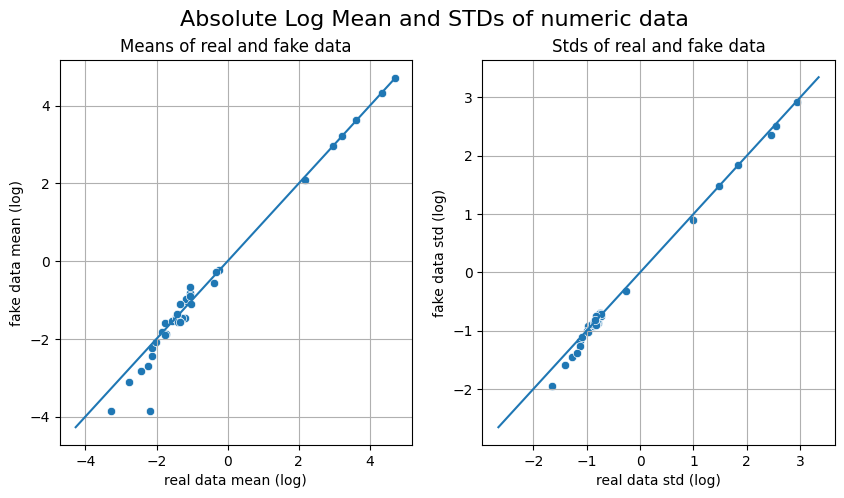

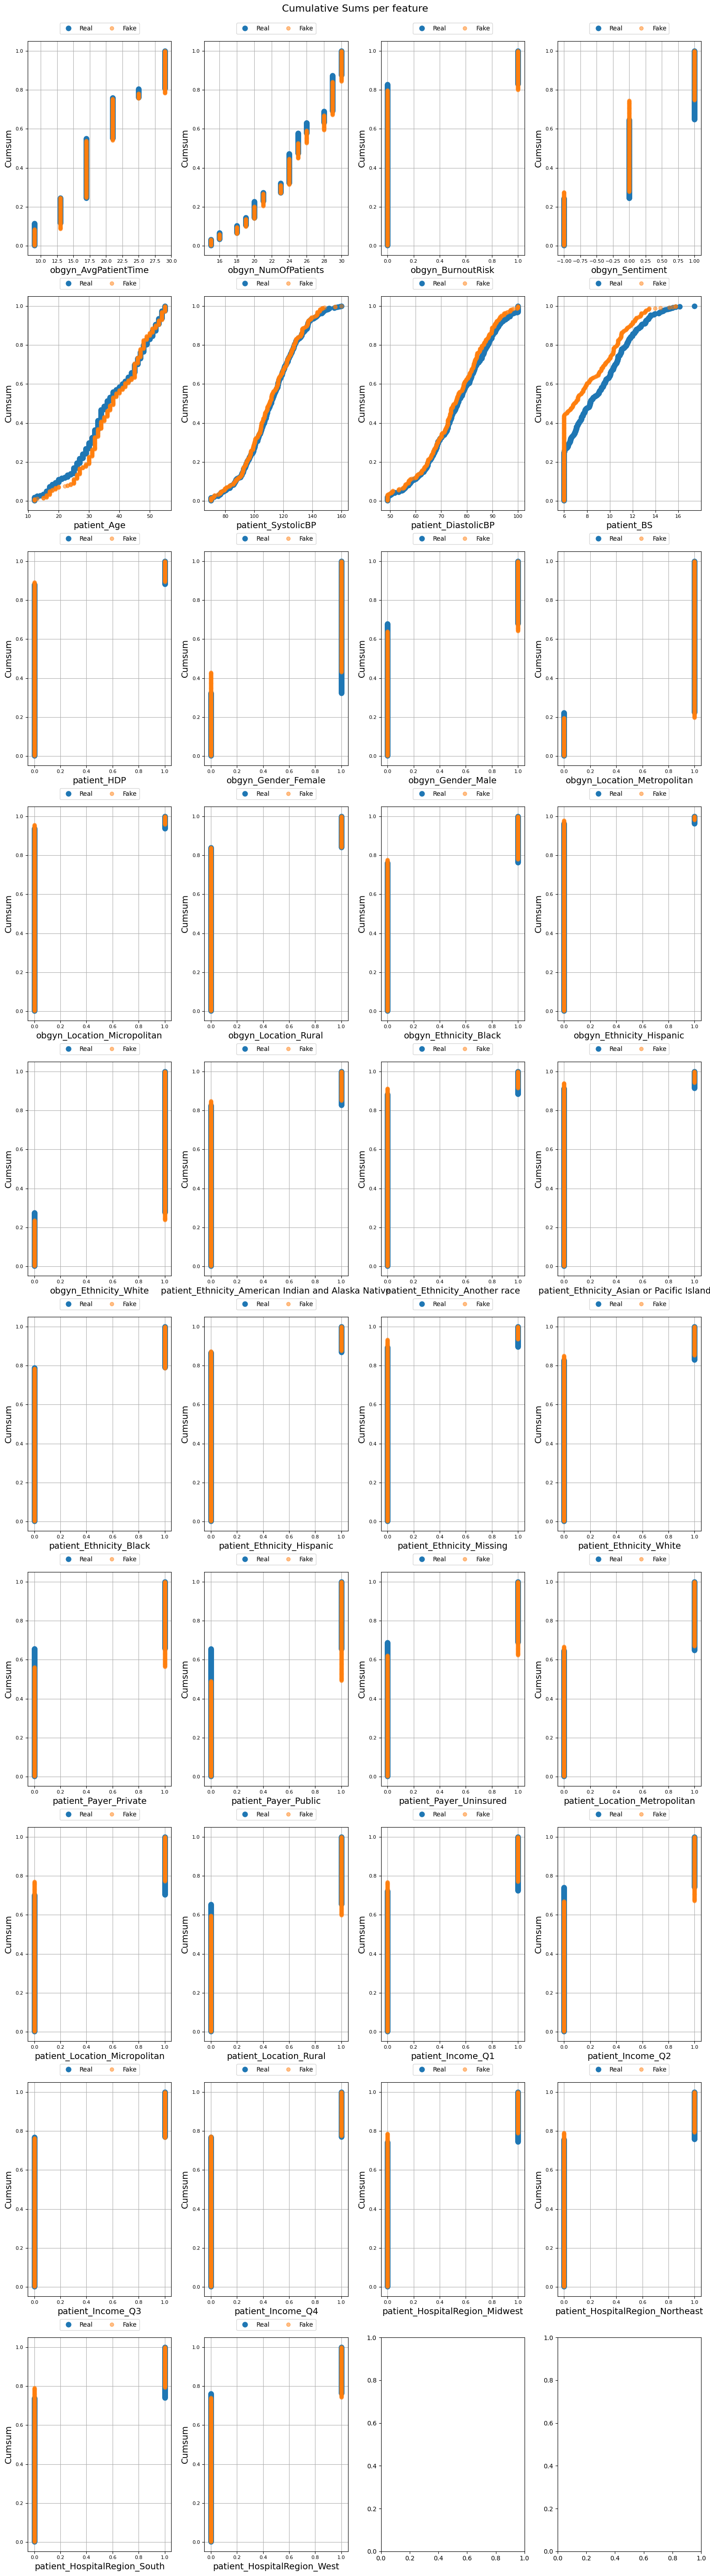

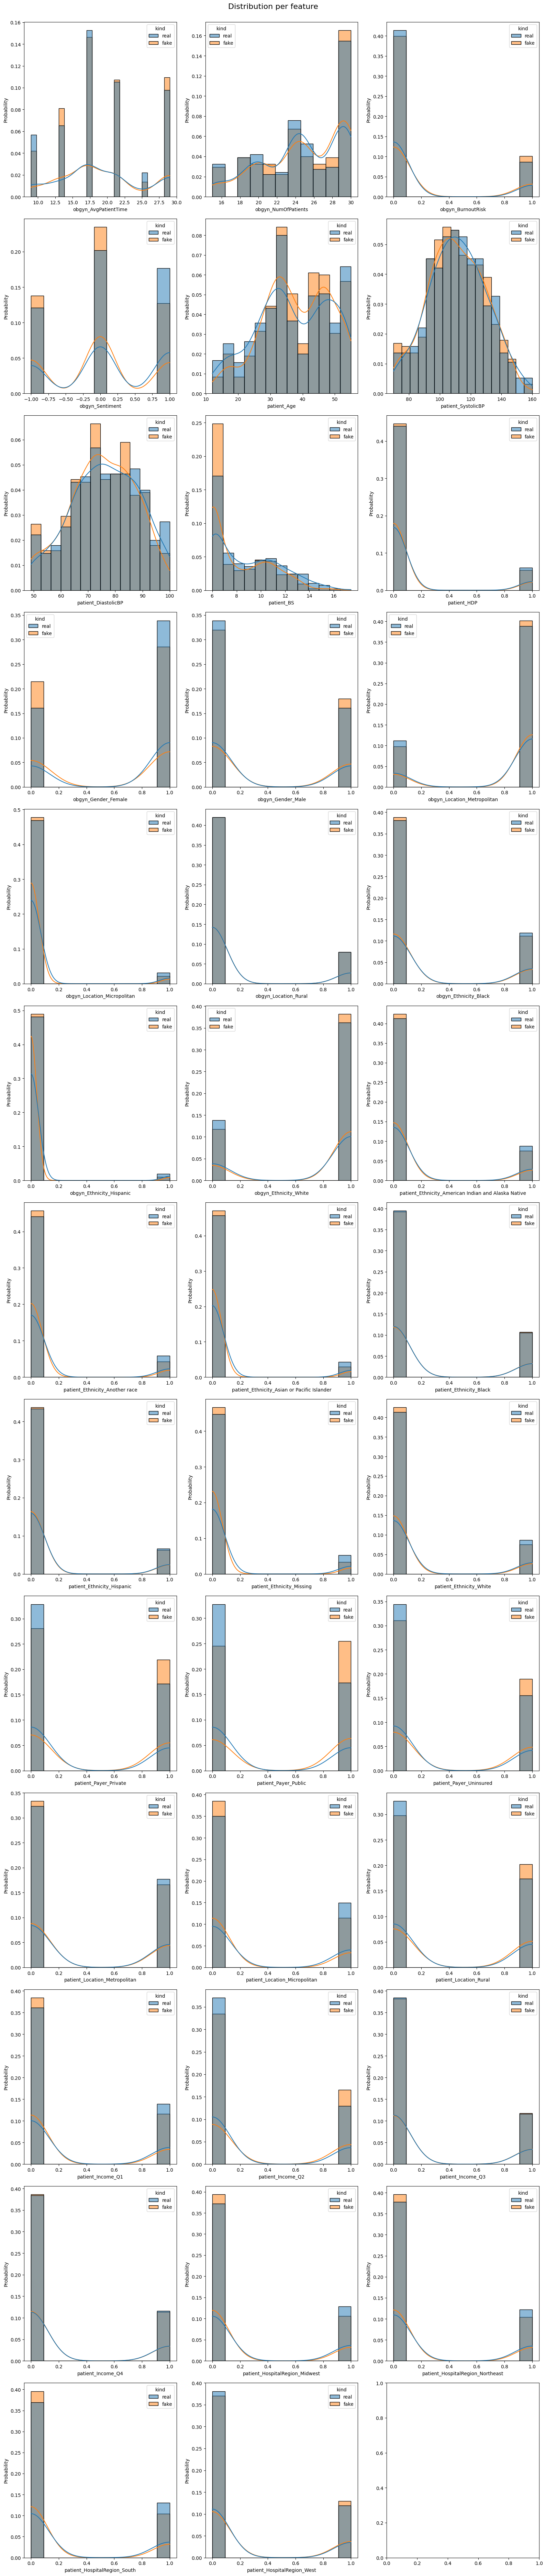

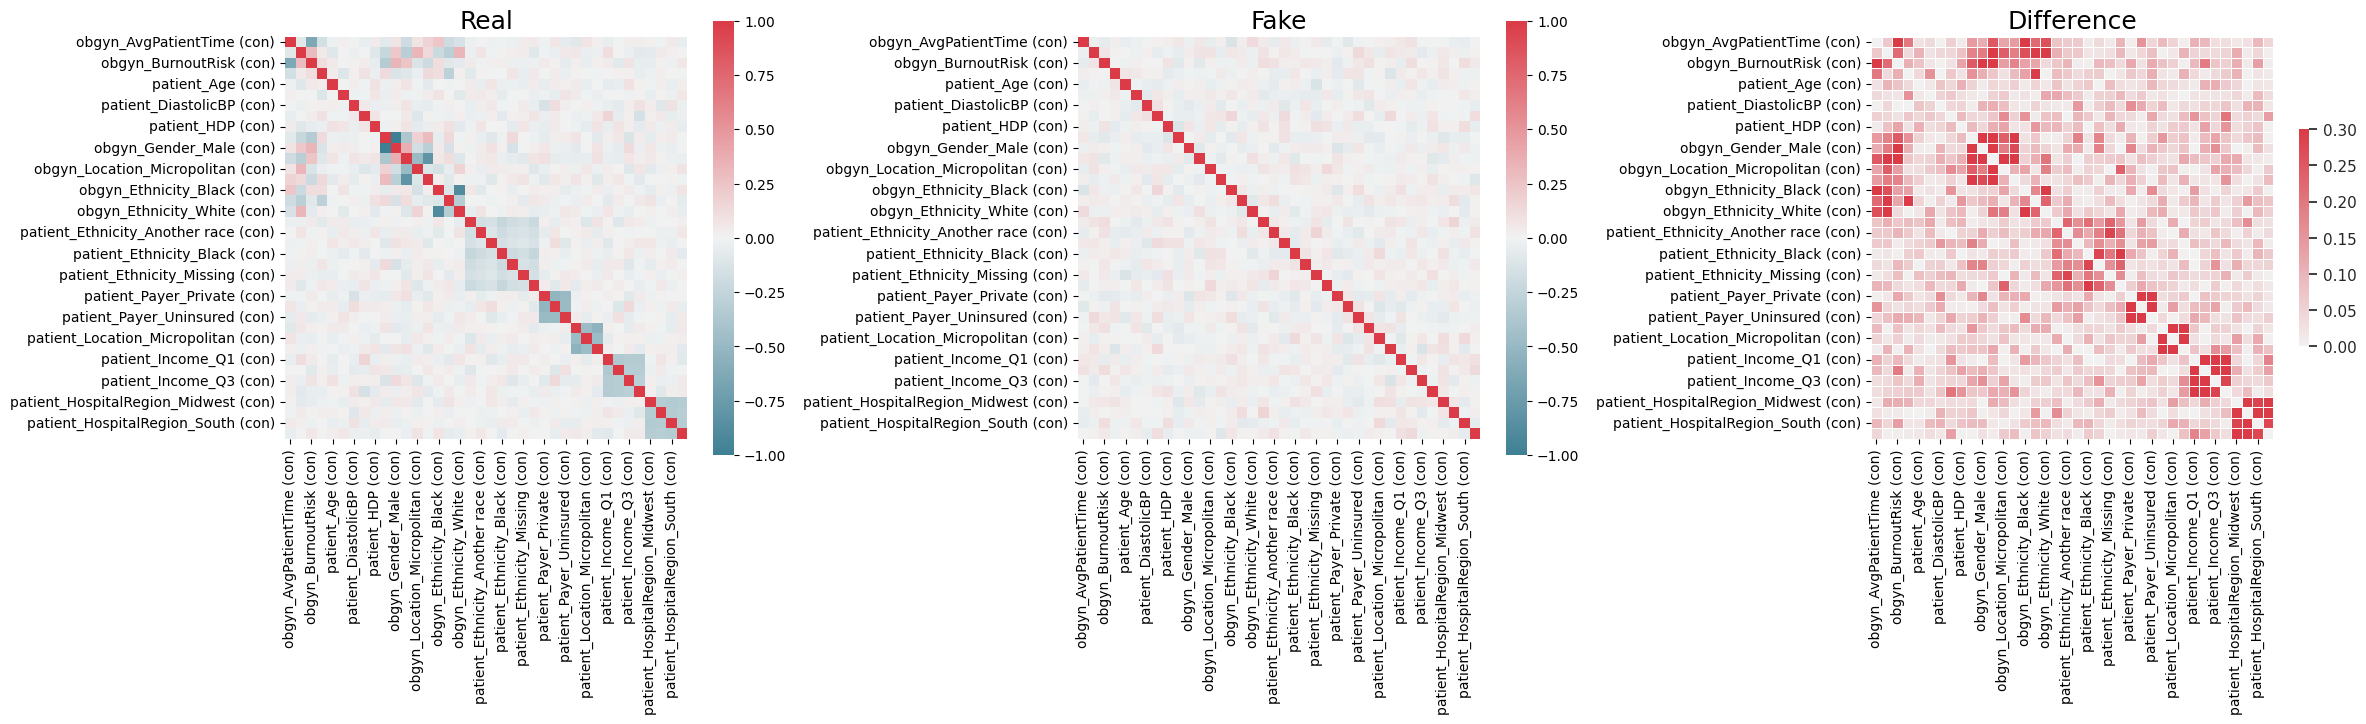

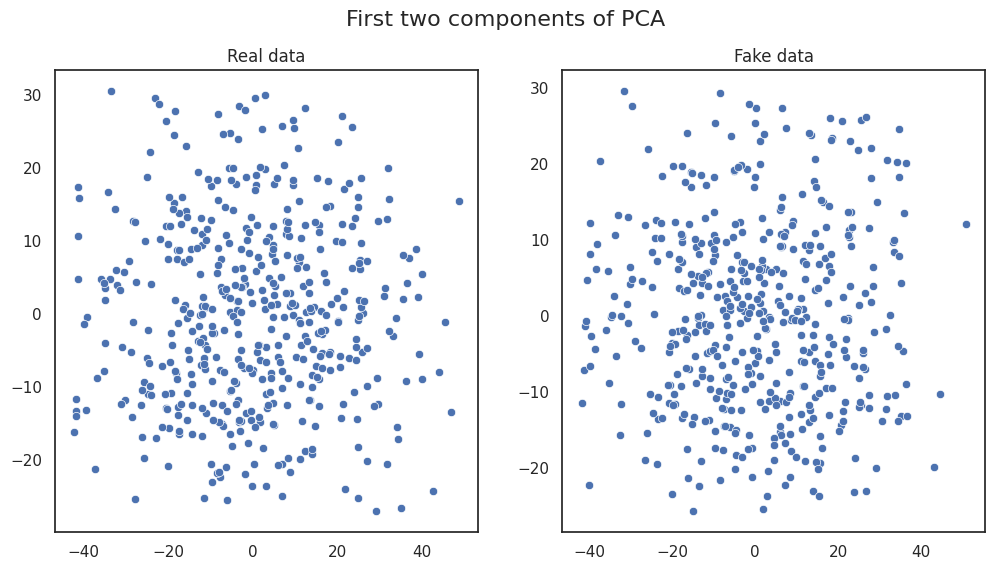

In [25]:
table_evaluator.visual_evaluation()